In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

#### 概述

该notebook为百度AI安全对抗赛的代码展示，主要使用的方法为PGD/BIM，叠加EOT和$L_2$-norm。

In [3]:
# 第一次运行该repo需要执行下列代码
# 解压缩文件，文件总大小约为5G，解压时间较长，请耐心等待

# import zipfile
# tar = zipfile.ZipFile('/home/aistudio/data/data19743/a_baidu_ai.zip','r')
# tar.extractall()

In [4]:
#coding=utf-8

# 加载预定义参数

'''
copyright @ baidu
copyright @ Team suibianwanwan
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import functools
import numpy as np
import paddle.fluid as fluid
import os
import sys

#加载自定义文件
import models
from attack.attack_pp import FGSM, PGD, PGDL2
from utils import init_prog, save_adv_image, process_img, tensor2img, calc_mse, add_arguments, print_arguments

#######parse parameters
parser = argparse.ArgumentParser(description=__doc__)
add_arg = functools.partial(add_arguments, argparser=parser)

# attack second time
add_arg('class_dim',        int,   121,                  "Class number.")
add_arg('start_idx',        int,   0,                    "start_idx.")
add_arg('end_idx',          int,   1,                  "end_idx.")
add_arg('num_steps',        int,   250,                  "num pgd steps.")
add_arg('eps',              float, 32.,                  "eps")
add_arg('step_size',        float, 0.02,                 "step size")
add_arg('noise_scale',      float, 0.6,                  "noise scale")
add_arg('confidence',       float, 20.,                  "early stop logit confidence")
add_arg('num_samples',      int,   5,                    "EOT samples")
add_arg('is_targeted',      int,   0,                    "0: means untargeted, 1: means targeted")
add_arg('shape',            str,   "3,224,224",          "output image shape")
add_arg('input',            str,   "./input_image/",     "Input directory with images")
add_arg('output',           str,   "./pgdl2_output_image_mobile_eot/",    "Output directory with images")
add_arg('model_name',       str,   "MobileNetV2",    "model name")
add_arg('subfix',           str,   ".jpg",    "sub fix")

In [5]:
# args = parser.parse_args()
args = parser.parse_known_args()[0]
print_arguments(args)

######Init args
image_shape = [int(m) for m in args.shape.split(",")]
class_dim=args.class_dim
input_dir = args.input
output_dir = args.output
if os.path.exists(output_dir) is False:
    os.mkdir(output_dir)
model_name=args.model_name
pretrained_model="./models_parameters/" + model_name
val_list = 'val_list.txt'

# Set gpu use or not
use_gpu=True

# Set target attack
if args.is_targeted == 0:
    IsTarget = False
elif args.is_targeted == 1:
    IsTarget = True

-------------  Configuration Arguments -------------
                class_dim : 121
               confidence : 20.0
                  end_idx : 1
                      eps : 32.0
                    input : ./input_image/
              is_targeted : 0
               model_name : MobileNetV2
              noise_scale : 0.6
              num_samples : 5
                num_steps : 250
                   output : ./pgdl2_output_image_mobile_eot/
                    shape : 3,224,224
                start_idx : 0
                step_size : 0.02
                   subfix : .jpg
----------------------------------------------------


### EOT

全称为Expectation over Transformation，具体操作为在input layer后添加旋转、裁切等操作，以此生成具有抗扰动的梯度
进行EOT后，针对进行随机变换的模型输入，对抗样本依然生效。


In [6]:
######Attack graph
adv_program=fluid.Program()
NUM_SAMPLES = args.num_samples
model = models.__dict__[model_name]()

#完成初始化
with fluid.program_guard(adv_program):
    # model definition
    input_layer = fluid.layers.data(name='image', shape=image_shape, dtype='float32')
    label = fluid.layers.data(name="label", shape=[1], dtype='int64')
    #设置为可以计算梯度
    input_layer.stop_gradient=False

    # add different transformations
    # 此处使用random noise和random noise两种EOT，目的是将扰动信息计入梯度，使得生成的扰动更加robust
    loss = 0
    for i in range(NUM_SAMPLES):
        if i == 0:
            scale_ratio = 1
            random_noise = fluid.layers.uniform_random(shape=[1, 3, 224, 224], min=-0.0001,
                                                       max=0.0001)
        else:
            # scale_ratio = np.random.uniform(low=1, high=9, size=1)[0]
            scale_ratio = i*1.0
            print(scale_ratio)
        # 1. random crop
        # cropped_img = fluid.layers.random_crop(input_layer, shape=[3, 170, 170])
        # 2. random noise
            random_noise = fluid.layers.uniform_random(shape=[1, 3, 224, 224], min=-args.noise_scale, max=args.noise_scale)
        noised_img = fluid.layers.elementwise_add(input_layer, random_noise)
        # 3. random noise
        scale_down = fluid.layers.image_resize(noised_img, scale=scale_ratio, name='scale_down_%d'%i, resample='BILINEAR')
        scale_back = fluid.layers.image_resize(scale_down, out_shape=(224, 224), name='scale_back_%d'%i, resample='BILINEAR')

        out_logits = model.net(input=scale_back, class_dim=class_dim)
        out = fluid.layers.softmax(out_logits)
        tmp_loss = fluid.layers.cross_entropy(input=out, label=label)
        loss += tmp_loss

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())
    # print(fluid.default_startup_program())
    #记载模型参数
    fluid.io.load_persistables(exe, pretrained_model)

#设置adv_program的BN层状态
init_prog(adv_program)

evala_program = fluid.Program()
with fluid.program_guard(evala_program):
    input_layer_eval = fluid.layers.data(name='image', shape=image_shape, dtype='float32')
    out_logits_eval = model.net(input=input_layer_eval, class_dim=class_dim)
    out_eval = fluid.layers.softmax(out_logits_eval)

#创建测试用评估模式
eval_program = evala_program.clone(for_test=True)
init_prog(eval_program)

#定义梯度
with fluid.program_guard(adv_program):
    gradients = fluid.backward.gradients(targets=loss, inputs=[input_layer])[0]


1.0
2.0
3.0
4.0


In [7]:
######Inference
def inference(img):
    fetch_list = [out_eval.name]

    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':img })
    result = result[0][0]
    pred_label = np.argmax(result)

    result_least = result[1:121]
    least_label = np.argmin(result_least) + 1
    pred_score = result[pred_label].copy()

    return pred_label, pred_score, least_label

### PGD

这里为了追求更小的MSE，采用基于$L_2$约束的PGD攻击

基于$L_\infty$的变化公式为：$x = x + \epsilon \times \text{sign}(g)$

基于$L_2$的变化公式为：$x = x + \epsilon \times \frac{g}{||g||_2}$

具体代码如下：

```python
def normalize_by_pnorm(x, p=2, small_constant=1e-6):
    """
    Normalize gradients for gradient (not gradient sign) attacks.
    # TODO: move this function to utils
    :param x: tensor containing the gradients on the input.
    :param p: (optional) order of the norm for the normalization (1 or 2).
    :param small_constant: (optional float) to avoid dividing by zero.
    :return: normalized gradients.
    """

    assert isinstance(p, float) or isinstance(p, int)
    x = x.reshape(-1, 224)
    norm = np.linalg.norm(x, ord=2)
    norm = max(norm, small_constant)
    x_norm = 1. / norm * x
    return x_norm.reshape(3, 224, 224)
```

In [8]:
######PGD attack
#untarget attack
def attack_by_PGD(img, src_label, target):
    pred_label = src_label

    step = float(args.step_size)
    eps = float(args.eps)

    # 生成对抗样本
    # 这里使用PGD-L2进行攻击
    adv = PGDL2(adv_program=adv_program, eval_program=eval_program,loss=loss,
    gradients=gradients,o=img, input_layer=input_layer,output_layer=out_logits,
                input_layer_eval=input_layer_eval,output_layer_eval=out_eval,
    step_size=step,epsilon=eps,iteration=int(args.eps/step),isTarget=IsTarget,target_label=target,src_label=src_label,
                use_gpu=True, discrete=False, confidence=args.confidence)

    pred_label, pred_score, _ = inference(adv)

    print("Test-score: {0}, class {1}".format(pred_score, pred_label))

    adv_img=tensor2img(adv)
    return adv_img

In [9]:
# 生成图片，准备攻击

####### Main #######
def get_original_file(filepath):
    with open(filepath, 'r') as cfile:
        full_lines = [line.strip() for line in cfile]
    cfile.close()
    original_files = []
    for line in full_lines:
        label, file_name = line.split()
        original_files.append([file_name, int(label)])
    return original_files

def gen_adv():
    mse = 0
    original_files = get_original_file('./input_image/' + val_list)

    # hard examples need use targeted attack
    for filename, label in original_files[args.start_idx:args.end_idx]:
        img_path = input_dir + filename.split('.')[0] + args.subfix
        print("Image: {0} ".format(img_path))
        img=process_img(img_path)
        
        # 此处可以指定target
        target = 0
        
        adv_img = attack_by_PGD(img, label, target)
        image_name, image_ext = filename.split('.')

        ##Save adversarial image(.png)
        save_adv_image(adv_img, output_dir+image_name+'.png')

        org_img = tensor2img(img)
        score = calc_mse(org_img, adv_img)
        mse += score
        print('MSE %.2f'%(score))
        sys.stdout.flush()
    print("ADV {} files, AVG MSE: {} ".format(len(original_files), mse/len(original_files)))
    
    return org_img, adv_img

In [10]:
if __name__ == '__main__':
    ori_img, adv_img = gen_adv()

Image: ./input_image/n02085620_10074.jpg 
istarget:  False
Non-Targeted attack target_label=1, o_label=1
iter: [0]/[1600], loss: 0.01, logits diff: 0.00
iter: [10]/[1600], loss: 0.01, logits diff: 0.00
iter: [20]/[1600], loss: 0.04, logits diff: 0.00
iter: [30]/[1600], loss: 2.80, logits diff: 0.00
iter: [40]/[1600], loss: 11.69, logits diff: 0.00
iter: [50]/[1600], loss: 17.87, logits diff: 0.00
iter: [60]/[1600], loss: 23.52, logits diff: 0.00
iter: [70]/[1600], loss: 28.48, logits diff: 0.00
iter: [80]/[1600], loss: 32.70, logits diff: 0.00
iter: [90]/[1600], loss: 36.68, logits diff: 0.00
iter: [100]/[1600], loss: 39.70, logits diff: 0.00
iter: [110]/[1600], loss: 42.60, logits diff: 0.00
iter: [120]/[1600], loss: 45.48, logits diff: 0.00
iter: [130]/[1600], loss: 47.75, logits diff: 0.00
iter: [140]/[1600], loss: 48.66, logits diff: 0.00
iter: [150]/[1600], loss: 49.91, logits diff: 0.00
iter: [160]/[1600], loss: 52.35, logits diff: 0.00
iter: [170]/[1600], loss: 54.18, logits dif

In [11]:
# RGB 转换

ori_img = ori_img[:, :, ::-1]
adv_img = adv_img[:, :, ::-1]

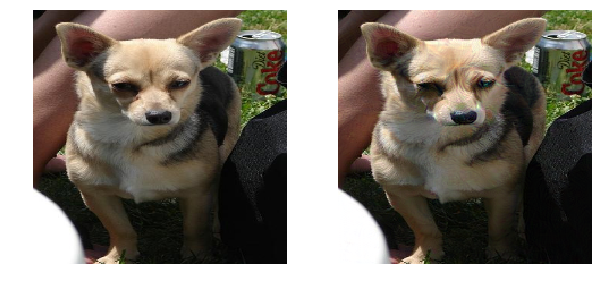

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(ori_img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.axis('off')
plt.show()

### 备注

以上就是使用$L_2$-norm based PGD+EOT攻击MobileNet的demo。

在本次比赛中，对抗样本的迁移性十分重要，为了在本地得到鲁棒的攻击样本，
我们先后训练了17个模型并依次攻击，训练使用了Transfer Learning，模型来自paddlepaddle官方的github，
链接如下：https://github.com/PaddlePaddle/models/tree/develop/PaddleCV/image_classification

感谢paddlepaddle和AIstudio为本次比赛提供支持。

若想要运行完整的攻击，请执行：
```
bash run_untargeted_with_eot_conf_15_noise_6_ensemble_13.sh
bash run_untargeted_without_eot_conf_15_ensemble_16.sh
bash run_targeted_without_eot_conf_18_ensemble_17.sh
```
